# Spring Sleep Analysis 
#### Studying springtime sleep habits though analysis of my Fitbit sleep data

In this notebook, I will study my spring quarter sleep habits with data extracted from my Fitbit Charge HR tracker. The data was obtained through use of Fitbit's API; detailed information about this can be found in `README.md` and `fitbit.py`. Each day's sleep data is stored in the /logs/ directory, in the format yyyy-mm-dd.json, which is the output of the `fitbit.py` script.

## Setup
Let's begin with importing what we need and configuring plots for later.

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import datetime
import scipy.stats

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 8.0]

Before we dive in, we must first understand the shape of the data. Refer to the [Fitbit documentation](https://dev.fitbit.com/docs/sleep/) for detailed information on the format of the log files. As a quick overview, each day contains two top-level attributes, `sleep` and `summary`:
 - `sleep` is a list of one or more entries for different sleep events in a day (e.g., a nap and then one's main sleep). Each entry has several attributes, like `isMainSleep`, `minutesAsleep`, and `minuteData`. `minuteData` contains minute-by-minute sleep data, where each minute has an identifier, `1`, `2`, or `3`, to denote asleep, restless, or awake.
 - `summary` contains summary statistics. It includes the number of sleep events (`totalSleepRecords`) and the total time in bed or asleep (`totalTimeInBed` and `totalMinutesAsleep`).

We can run a couple of simple commands to illustrate this.

In [2]:
with open('logs/2016-07-01.json') as f:
    sample_data = json.loads(f.read())
list(sample_data.keys())

['summary', 'sleep']

In [3]:
list(sample_data['summary'].keys())

['totalMinutesAsleep', 'totalTimeInBed', 'totalSleepRecords']

In [4]:
list(sample_data['sleep'][0].keys())

['restlessCount',
 'awakeCount',
 'restlessDuration',
 'logId',
 'dateOfSleep',
 'duration',
 'timeInBed',
 'startTime',
 'minutesAsleep',
 'awakeningsCount',
 'efficiency',
 'awakeDuration',
 'minuteData',
 'minutesAfterWakeup',
 'isMainSleep',
 'minutesToFallAsleep',
 'minutesAwake']

## Time Spent in Bed
How long was I in bed each night? I restrict my analysis to the spring academic term at my school (March 29th to June 10th). 

(I am choosing to study `totalTimeInBed`, rather than `totalMinutesAsleep`, for a couple of reasons. I generally fall asleep quickly and sleep well; I rarely get up in the middle of the night; and a quick look at the distributions shows them as being very similar. I choose to study the dataset that counts time I was 'restless.')

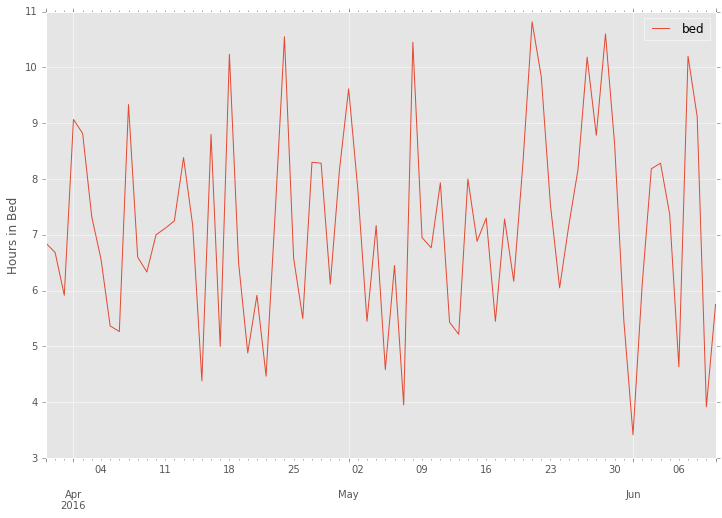

In [5]:
dates = pd.date_range('2016-03-29', '2016-06-10')
time_in_bed = []

for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname) as f:
        date_data = json.loads(f.read())
        
        time_in_bed.append(date_data['summary']['totalTimeInBed'] / 60.0)
        
df = pd.DataFrame(time_in_bed, index = dates)
df.columns = ['bed']

df.plot()
plt.ylabel('Hours in Bed');

As interesting as this looks, there isn't a whole lot to take from it on the surface. The vague periodicity of the graph sugggests that we look at different days of the week, so we'll do that soon. Let's first look at the distribution of how long I was in bed.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bed,74.0,7.154955,1.786836,3.416667,5.916667,7.141667,8.283333,10.816667


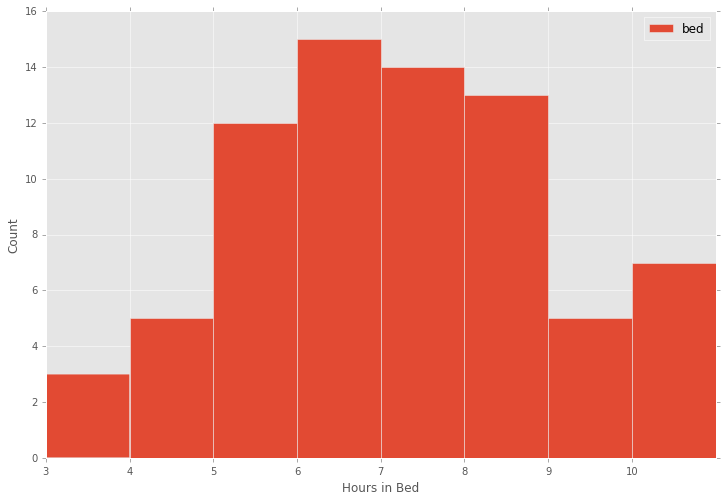

In [7]:
df.plot.hist(bins = 8, range = (3, 11))

plt.xlim(3, 11)
plt.xticks(range(3, 11))
plt.xlabel('Hours in Bed')
plt.ylabel('Count');

As far as behavioral data goes, this is reasonably well-behaved. Notice that this distribution varies quite a bit, with a standard deviation of nearly two hours. (Anyone familiar with the sleep habits of a college student will not be surprised.)

## Sleep Paterns by Day of Week

Let's now look at the different days of the week. Did I sleep more on weekends? (I certainly hope so.) What nights were the worst? We can add another identifier denoting the day of the week, and then group the days based on whether they were weekdays or weekends. We'll then look at the distriutions and compare them with a t-test.

Note that a sleep record for a certain day (e.g., Friday) contains data from the previous night (in that case, Thursday night). Also, `pandas` numbers days as 0 = Monday, ... ,  6 = Sunday. Altogether, this means weekdays are labeled 0 through 4, and weekends are labeled 5 and 6.

In [8]:
df['day_of_week'] = df.index.weekday
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df.head()

,bed,day_of_week,day_type
2016-03-29,6.850000,1,Weekday
2016-03-30,6.683333,2,Weekday
2016-03-31,5.916667,3,Weekday
2016-04-01,9.066667,4,Weekday
2016-04-02,8.816667,5,Weekend


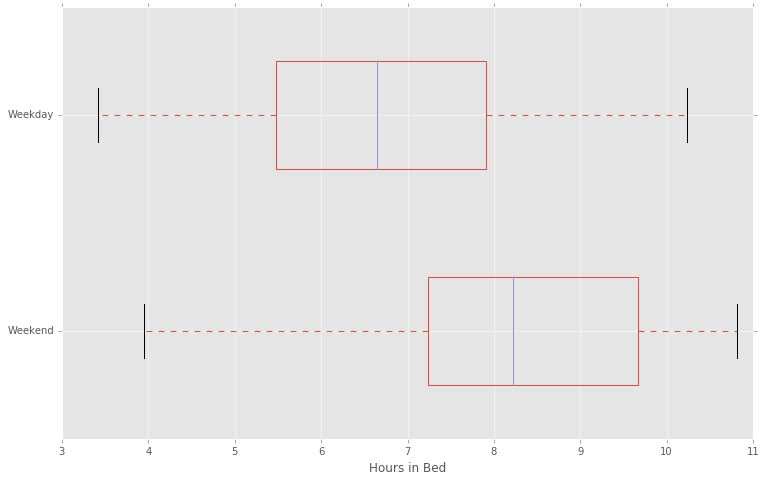

In [9]:
df.boxplot(column = 'bed', by = 'day_type', positions = [2, 1], 
           vert = False, widths = 0.5)
plt.xlabel('Hours in Bed')
plt.suptitle('')
plt.title('');

In [10]:
# Group dataframe by weekday vs. weekend
df_weekdays = df[df.day_of_week < 5]
df_weekend = df[df.day_of_week >= 5]

scipy.stats.ttest_ind(df_weekdays['bed'], df_weekend['bed'])

Ttest_indResult(statistic=-3.2541604345082797, pvalue=0.0017337202641399434)

A low p-value would suggest I sleep statistically significantly more on weekends than on weekdays. The two boxplots illustrate this observation. I'm not at all surprised by this, but it's always cool to have data to back up your intuition.

What about individual days? We can consider each night of the week separately, and look at the distributions there.

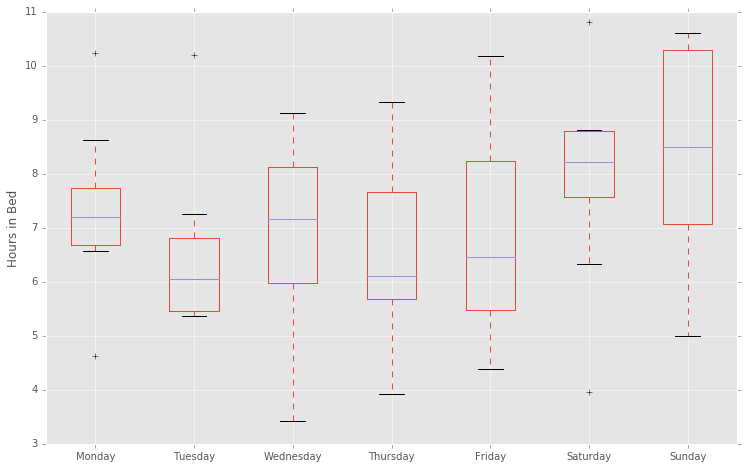

In [11]:
# Add a label for day name, to make the boxplot more readable
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
        5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].apply(lambda x: days[x])

df.boxplot(column = 'bed', by = 'day_name', positions = [5, 1, 6, 7, 4, 2, 3])

# Configure title and axes
plt.suptitle('')
plt.title('')
plt.ylabel('Hours in Bed')
plt.xlabel('');

This is very illustrative. Tuesdays, Thursdays, and Fridays were the days on which I got the least amount of sleep the previous night. Looking back on my quarter, I can find explanations for all of these -- Monday nights were extremely busy, and I could not start work until pretty late; Thursday mornings, I had to wake up earlier than usual to go to work, impacting my sleep the night before; and on Fridays, I had a quantum mechanics problem set due, which was too often put off to the night before. I find it extremely interesting to see my academic habits reflected in my sleep habits.

## Bedtimes

I've learned quite a bit about how much I sleep. What about _when_ I sleep? Let's create a new dataset; this one will have columns for bedtime (formally defined as the start of any sleep event, including naps), for the time I was in bed (as before), and for whether or not it was a 'main sleep' (the longest sleep event of a 24-hour period, distinguishing regular sleep from naps).

Let's look at my sleep duration versus my bedtime. While the next two code blocks are pretty large, their purposes are straightforward: we want to create the dataset described above, then plot it.

In [12]:
bedtimes = []

# Read data into list
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname) as f:
        date_data = json.loads(f.read())
        
        # Note that sleep_event['startTime'][11:16] gets the hh:mm characters
        # from the start of a sleep event; it is then converted to a datetime
        for sleep_event in date_data['sleep']:
            bedtimes.append((pd.to_datetime(sleep_event['startTime'][11:16]), 
                             sleep_event['timeInBed'] / 60.0,
                             sleep_event['isMainSleep']))
            
# Convert to dataframe, and make 'bedtime' a float (e.g., 5:30 -> 5.5)
df = pd.DataFrame(bedtimes, columns = ['bedtime', 'duration', 'main'])
df['bedtime'] = df['bedtime'].dt.hour + df['bedtime'].dt.minute / 60.0

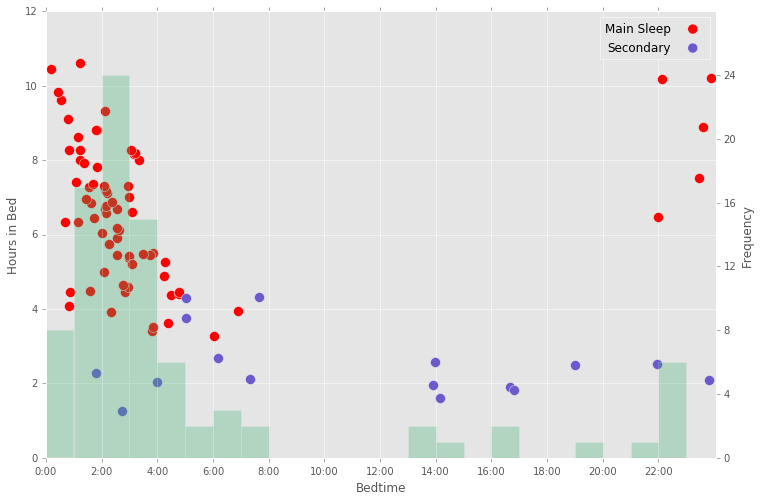

In [13]:
# Make first plot: scatterplot of bedtime vs. duration, colored by main sleep
ax = df[df.main == True].plot.scatter(x = 'bedtime', y = 'duration', 
                                      color = 'Red', s = 100, 
                                      label = 'Main Sleep')

df[df.main == False].plot.scatter(x = 'bedtime', y = 'duration', 
                                  color = 'SlateBlue', ax = ax, s = 100, 
                                  label = 'Secondary')

# List of times to use for labels
times = [str(2 * h) + ':00' for h in range(12)]

# Configure legend, x-axis, labels
plt.legend(scatterpoints = 1, markerfirst = False)
plt.xticks(range(0, 24, 2), times)
plt.xlim(0, 24)
plt.xlabel('Bedtime')
plt.ylabel('Hours in Bed');

# Overlay a histogram of bedtimes on the same plot, using a secondary y-axis
ax2 = ax.twinx()
df['bedtime'].map(lambda x: int(x)).plot.hist(bins = range(24), 
                                              color = 'MediumSeaGreen', 
                                              alpha = 0.3, grid = False)

# Configure secondary y-axis
plt.yticks(range(0, 28, 4))
plt.ylim(0, 28);

There is a clear negative correlation between my bedtime and my time spent in bed; it's no surprise that the later I go to bed, the less sleep I get.

But some other things can be read from this plot -- I most frequently went to bed between 2:00 and 3:00 am, for instance, followed by between 1:00 and 2:00, then 3:00 to 4:00. I rarely slept before 1:00, and even less so before midnight. I didn't take very many naps (note also that not every secondary sleep event is a nap), but when I did, they were around two or three hours in length.

## Final Remarks
Data is great, but its purpose is ultimately to give insight into a larger picture. What can I learn from this dive into my sleep habits?

Clearly, **my sleep durations vary a lot.** We noticed a standard deviation of nearly two hours on the distribution of sleep durations. I sleep wildly different amounts each night; it would likely be healthier for me to work towards sleeping more consistently.

From the section "Sleep Patterns by Day of Week," we notice that **my workload is reflected in my sleep habits**. I slept noticably less on nights where I had something due the following day. The solution, which is much easier said than done, is to start work earlier -- every student's goal. Similarly, **I sleep more on weekends.** The immediate explanation for this observation is that I'm trying to make up for getting less sleep during the week. But this idea of "catching up on sleep" has been [often](https://sleepfoundation.org/sleep-news/you-cant-catch-sleep) [debated](http://www.scientificamerican.com/article/fact-or-fiction-can-you-catch-up-on-sleep/) by scientists, and it is unclear whether this is actually possible. 

**Future directions** for this project include analyzing and comparing sleep data from fall, winter, and spring terms. Each quarter was very different, posing its own set of challenges; can I see this reflected in my sleep patterns? Similarly, I could consider how these patterns change during summer. Finally, I might also consider making use of the nightly, minute-by-minute data. 